<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/DL_1_homework_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Основы PyTorch

## Задача №1

- Объявите вещественные тензор `x` размера (3, 4, 5) и тензор `y` размера (2, 6, 5), иницилизируйте их равномерным распределением. 
- Создайте их копии на GPU, выведите их сумму и разность
- Затем измените форму тензора `y`, чтобы она совпадала с формой тензора `x`, получите тензор `z`  
- Переместите `z` на CPU

In [136]:
import torch
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt

In [137]:
x = torch.FloatTensor(3,4,5).uniform_()# ВАШ КОД ЗДЕСЬ
y = torch.FloatTensor(2,6,5).uniform_()# ВАШ КОД ЗДЕСЬ

In [138]:
x_cuda = x.cuda()# ВАШ КОД ЗДЕСЬ
y_cuda = y.view(3,4,5).cuda()# ВАШ КОД ЗДЕСЬ

RuntimeError: ignored

In [ ]:
print("Сумма = ", x_cuda.add(y_cuda))# ВАШ КОД ЗДЕСЬ)
print("Разность = ",x_cuda.sub(y_cuda)) # ВАШ КОД ЗДЕСЬ)

In [ ]:
z = y.view(3,4,5)# ВАШ КОД ЗДЕСЬ

In [ ]:
z = z.cpu()# ВАШ КОД ЗДЕСЬ

# Задача №2. Функции активации

Мы поняли, что пороговая функция активации сулит нам много проблем. Что если попробовать что-то другое?

Начнем с сигмоиды.

У сигмоиды все в порядке с производной. Можем взять производную функции потерь по весам и спускаться в пространстве параметров в направлении наискорейшего убывания функции потерь. Формула для обновления весов в градиентном спуске:

$$w^{j+1} = w^{j} - \alpha \frac{\partial Loss}{\partial w} (w^{j})$$

Распишем дальше:

* Для веса $w_j$:

$$ \frac{\partial Loss}{\partial w_j} = 
\frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)(\sigma(w \cdot x_i))_{w_j}' = \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij}$$

* Градиент функции потерь по вектору весов - это вектор, $j$-ая компонента которого равна $\frac{\partial Loss}{\partial w_j}$:

$$\begin{align}
    \frac{\partial Loss}{\partial w} &= \begin{bmatrix}
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i1} \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{i2} \\
           \vdots \\
           \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{im}
         \end{bmatrix}
\end{align}=\frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

Таким образом, сигмоида отлично подходит. Осталось реализовать в коде. 

* Реализуйте сигмоиду и её производную:

In [139]:
def sigmoid(x): # sigmoid
    return 1/(1+np.exp(-x))
    

In [140]:
def sigmoid_derivative(x): # subj
    #how fast sigmoid changes with small changes in input
    s = sigmoid(x)
    return s * (1-s)

In [141]:
def mse_loss(y_pred, y): # функция потерь
    y_pred = y_pred.reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)

    return 0.5 * np.mean((y_pred - y) ** 2)

In [142]:
class Perceptron_Sigmoid:
    def __init__(self, w=None, b=0):

        self.w = w 
        self.b = b
  
    def activate(self, x):
      '''activation func'''
      return sigmoid(x) # activation func
        
    def forward(self, X): # прямой проход
        '''features @ weights and fit into activation'''
        y_pred = np.dot(X, self.w) + self.b   # y = mx + b update
        y_pred = self.activate(y_pred)        #  activation function on new predicted
        return y_pred.reshape(-1,1)           # form a vector with 1 column
    
    def backward(self, X, y, y_pred, learning_rate=0.005): # backpropogation

        n = X.shape[0]
        y = np.array(y).reshape(-1,1)
        normal = 1/n
        
        y_diff = y_pred - y                       # real error of y

        y_d_sig = sigmoid_derivative(y_pred)      #slope of change of sugmoid with predicted inputs
        wgrad = X.T @ (y_diff * y_d_sig)                    # input values @ pure error = gradient with respect to weights
    

        dw =  normal * wgrad#                  # normalization * wgrad * rate of change of sigmoid 
        db = normal * y_diff.mean(axis=0) * y_d_sig        # normalization * total error number * vector of derivative of sigmoid

        self.w -= learning_rate*dw
        self.b -= learning_rate*db
    
    def fit(self, X, y, num_epochs=5000):

        self.w = np.zeros((X.shape[1], 1))  # вектор весов
        self.b = 0  # смещение
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward(X)
            loss_values.append(mse_loss(y_pred,y))
            self.backward(X,y,y_pred)
        
        return np.array(loss_values)

In [143]:
def random_mix(X_1, X_2): # перемешиваем
    c = np.concatenate((X_1, X_2))
    np.random.shuffle(c)
    return c

In [144]:
rng = np.random.default_rng()
data_0 = np.concatenate([rng.normal((-1, -1), 1, (500, 2)), np.zeros((500, 1))], axis=1) # сэмплируем нули
data_1 = np.concatenate([rng.normal((1, 1), 1, (500, 2)), np.ones((500, 1))], axis=1) # сэмплируем единицы
data = random_mix(data_0, data_1) # получаем наш набор данных

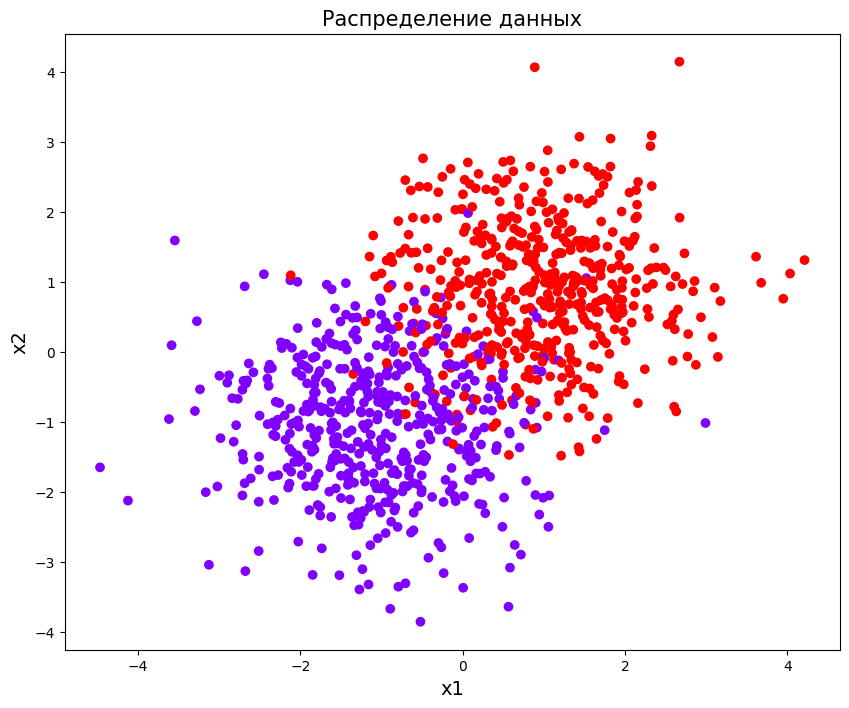

In [145]:
plt.figure(figsize=(10, 8)) # отрисуем его
plt.scatter(data[:, 0], data[:, 1], c=data[:, 2], cmap='rainbow') # ВАШ КОД ЗДЕСЬ
plt.title('Распределение данных', fontsize=15)
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.show()

In [146]:
X = data[:, :-1] # обучающая выборка
y = data[:, -1] # целевая переменная

X

array([[-0.15850407, -1.98335664],
       [-1.22860188, -1.03784439],
       [-2.61029187, -1.80093368],
       ...,
       [ 0.68792868,  1.72848038],
       [-1.92644183, -1.91181414],
       [ 1.60118146,  2.17397085]])

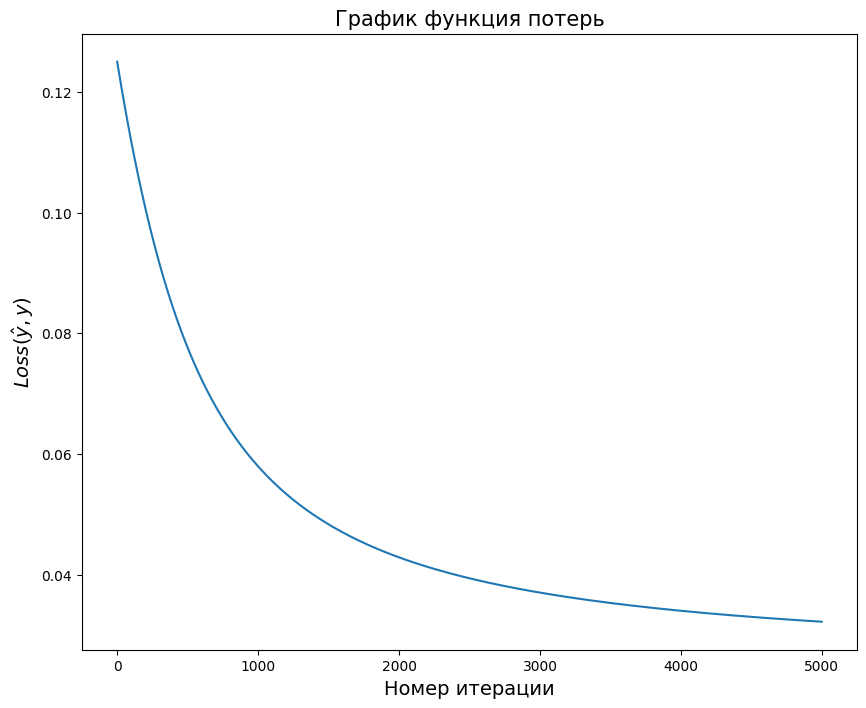

In [147]:
perceptron = Perceptron_Sigmoid()
losses = perceptron.fit(X,y)

plt.figure(figsize=(10, 8))
plt.plot(losses) # ВАШ КОД ЗДЕСЬ)
plt.title('График функция потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Вуаля! Наконец, мы видим, что наш перцептрон обучается.

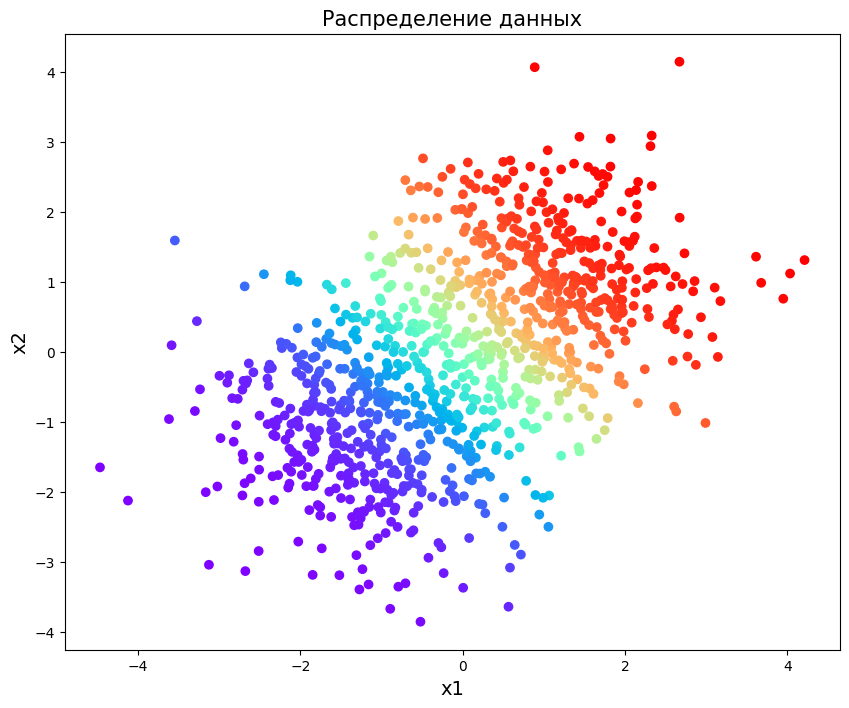

In [148]:
def plot_perc(perceptron):
  plt.figure(figsize=(10, 8))
  plt.scatter(data[:, 0], data[:, 1], c=perceptron.forward(X).ravel(), cmap='rainbow') # ВАШ КОД ЗДЕСЬ # отрисуем ответы перцептрона
  plt.title('Распределение данных', fontsize=15)
  plt.xlabel('x1', fontsize=14)
  plt.ylabel('x2', fontsize=14)
  plt.show()

plot_perc(perceptron)

Однако данные все равно разделяет линейно. 

In [149]:
print(accuracy_score(perceptron.forward(X).ravel()>0.5, y)) # рассчитаем значение accuracy

0.931


Может быть нам поможет ReLU()? Ведь про сигмоиду мы знаем, что у нее затухают градиенты. 

ReLU выглядит очень просто:

\begin{equation*}
ReLU(x) =
 \begin{cases}
   0, &\text{$x \le 0$}\\
   x, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Или по-другому:

$$
ReLU(x) = \max(0, x)
$$

В переводе Rectified Linear Unit = "Усечённая линейная функция". Мы по сути просто не даём проходить отрицательным числам.

Производная здесь берётся как производная от кусочно-заданной функции, то есть на участках, где функция гладкая, и в нуле её доопредляют нулём:

\begin{equation*}
ReLU'(x) = 
 \begin{cases}
   0, &\text{$x \le 0$}\\
   1, &\text{$x \gt 0$}
 \end{cases}
\end{equation*}

Подставим ReLu в Loss:

$$Loss(\hat{y}, y) = \frac{1}{2n}\sum_{i=1}^{n} (\hat{y_i} - y_i)^2 = \frac{1}{2n}\sum_{i=1}^{n} (ReLU(w \cdot X_i) - y_i)^2 = \begin{equation*}
\frac{1}{2n}\sum_{i=1}^{n}
 \begin{cases}
    y_i^2, &{w \cdot X_i \le 0}\\
   (w \cdot X_i - y_i)^2, &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$  

Тогда формула для обновления весов при градиентном спуске будет такая:

$$ \frac{\partial Loss}{\partial w} = \begin{equation*}
\frac{1}{n}\sum_{i=1}^{n}
 \begin{cases}
   0, &{w \cdot X_i \le 0}\\
   \frac{1}{n} X_i^T (w \cdot X_i - y), &{w \cdot X_i \gt 0}
 \end{cases}
\end{equation*}$$

Почему в первом случае будет 0? Потому что в $y_i^2$ не входят веса , а мы берём производную именно по весам $w$.

* Реализуйте ReLU и её производную:

In [150]:
def relu(x):
    return np.maximum(0,x) # ВАШ КОД ЗДЕСЬ

In [151]:
def relu_derivative(x):
    return (x > 0).astype(int) #convert bools to ints basically 1 if relu(x) > 0 else 0 # ВАШ КОД ЗДЕСЬ

In [244]:
class Perceptron_ReLU:
    def __init__(self, w=None, b=0, zeros = True):

        self.zeros = zeros
        self.w = w
        self.b = b
        
    def activate(self, x):
        return relu(x)
        
    def forward(self, X):

        #n = X.shape[0]             #why n in forward?! 
        y_pred = np.dot(X, self.w) + self.b # ВАШ КОД ЗДЕСЬ
        y_pred = self.activate(y_pred)# ВАШ КОД ЗДЕСЬ
        return y_pred.reshape(-1,1)
    
    def backward(self, X, y, y_pred, learning_rate=0.005):

        n = len(y)
        y = np.array(y).reshape(-1, 1)
        y_diff = y_pred - y

        y_d_relu = relu_derivative(y_pred)


        wgrad =  X.T @ (y_diff * y_d_relu)
  
        dw = wgrad / n       #     #same as 1/n * wgrad ВАШ КОД ЗДЕСЬ
        db =  np.sum(y_diff * y_d_relu) /n  # or np.sum(y_diff) * y_d_relu / n
        #y_diff.mean(axis=0) * y_d_relu/n   #or (y_diff* y_d_relu).mean(axis=0)/n
        #^ something wrong here


        self.w -= learning_rate*dw 
        self.b -= learning_rate*db
    
    def fill_w_zeros(self,X):
      self.w = np.zeros((X.shape[1], 1))

    def fit(self, X, y, num_epochs=5000):

        if self.zeros:
         self.fill_w_zeros(X)
        # if self.zeros else self.w # вектор весов
        self.b = 0  # смещение (число)
        loss_values = []  # значения функции потерь на различных итерациях обновления весов
        
        for i in range(num_epochs):
            y_pred = self.forward(X)
            loss_values.append(mse_loss(y_pred,y))
            self.backward(X,y,y_pred)
        
        return np.array(loss_values)

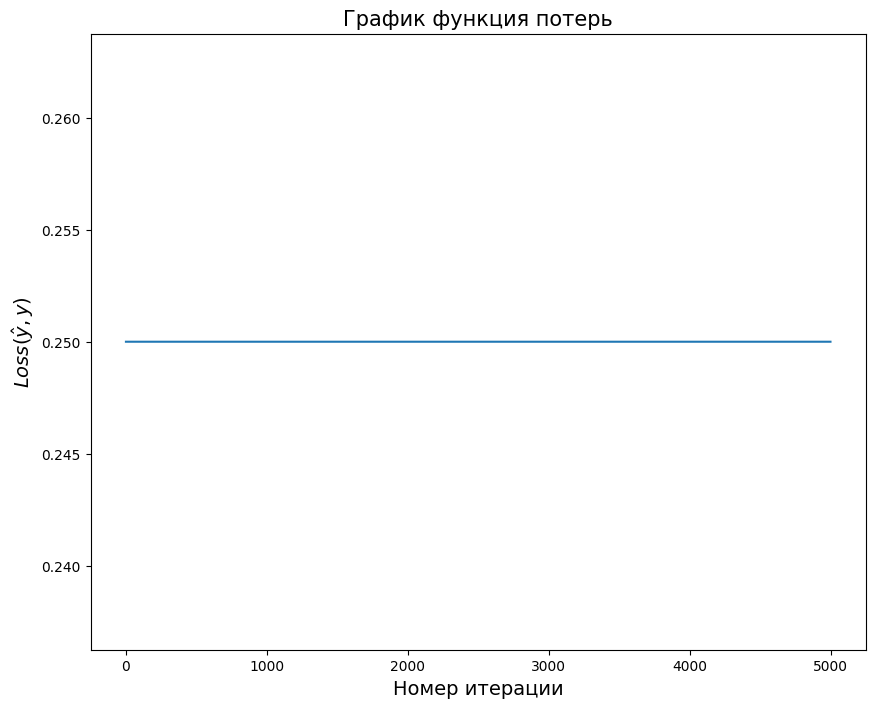

In [245]:
perceptron_r = Perceptron_ReLU()
losses = perceptron_r.fit(X,y)

plt.figure(figsize=(10, 8))
plt.plot(losses)# ВАШ КОД ЗДЕСЬ)
plt.title('График функция потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

Что мы видим? Что произошло с функцией потерь? 

Ничего удивительного, поскольку одна из проблем ReLU() это так называемые "мертвые" нейроны. А наши веса ведь изначально инициализированы нулями! Поэтому обучение и не происходит.

Заинициализируем их случайными числами (не забудьте закомментировать в классе инициализацию нулями):

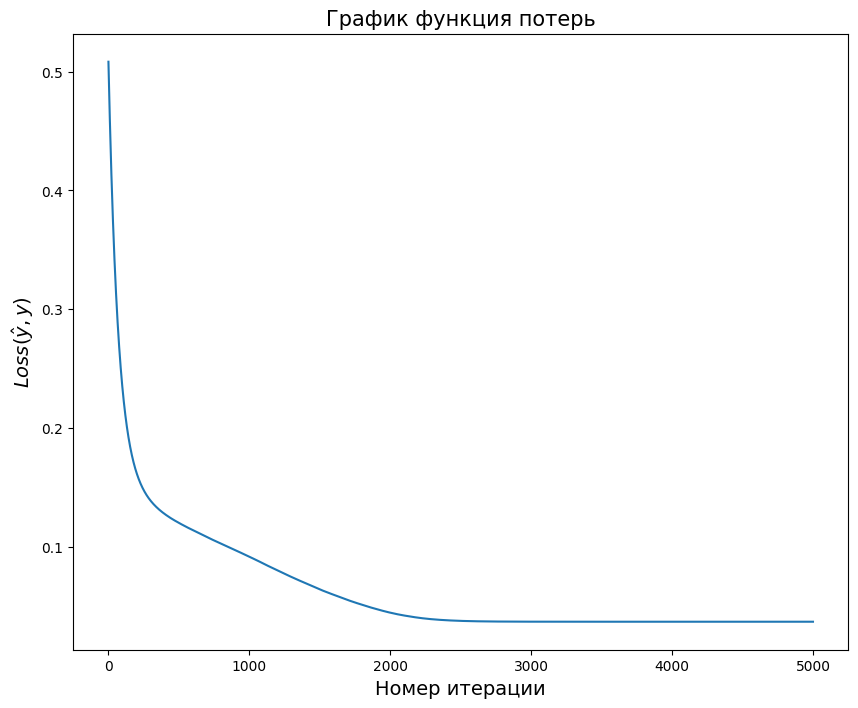

In [246]:
rng = np.random.default_rng()
perceptron_r = Perceptron_ReLU(w = rng.normal(size = (X.shape[1], 1)), zeros=False)     # ВАШ КОД ЗДЕСЬ)
losses = perceptron_r.fit(X, y, num_epochs=5000)

plt.figure(figsize=(10, 8))
plt.plot(losses.reshape(-1,))
plt.title('График функция потерь', fontsize=15)
plt.xlabel('Номер итерации', fontsize=14)
plt.ylabel('$Loss(\hat{y}, y)$', fontsize=14)
plt.show()

sigmoid


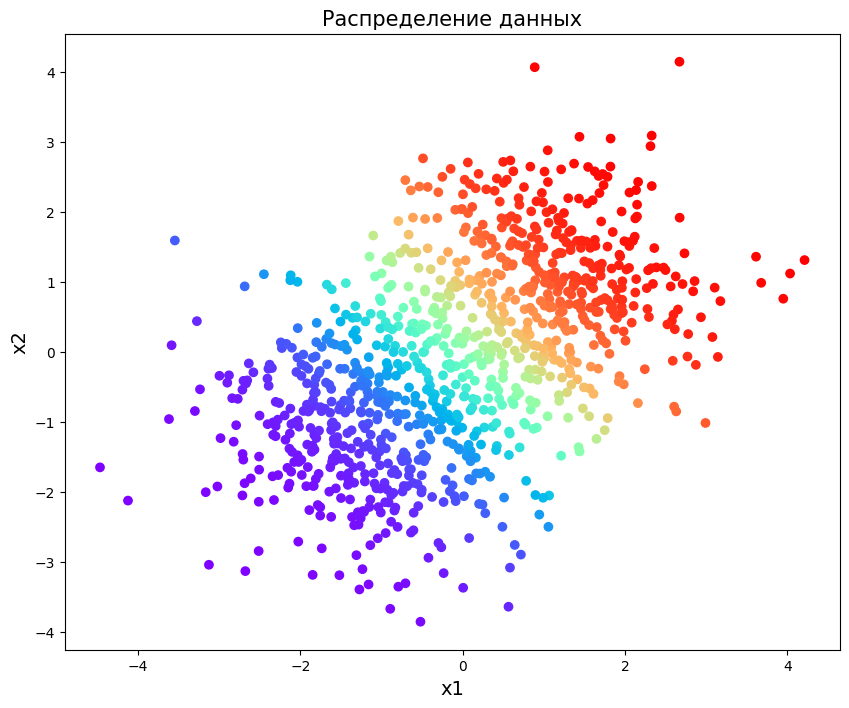

relu


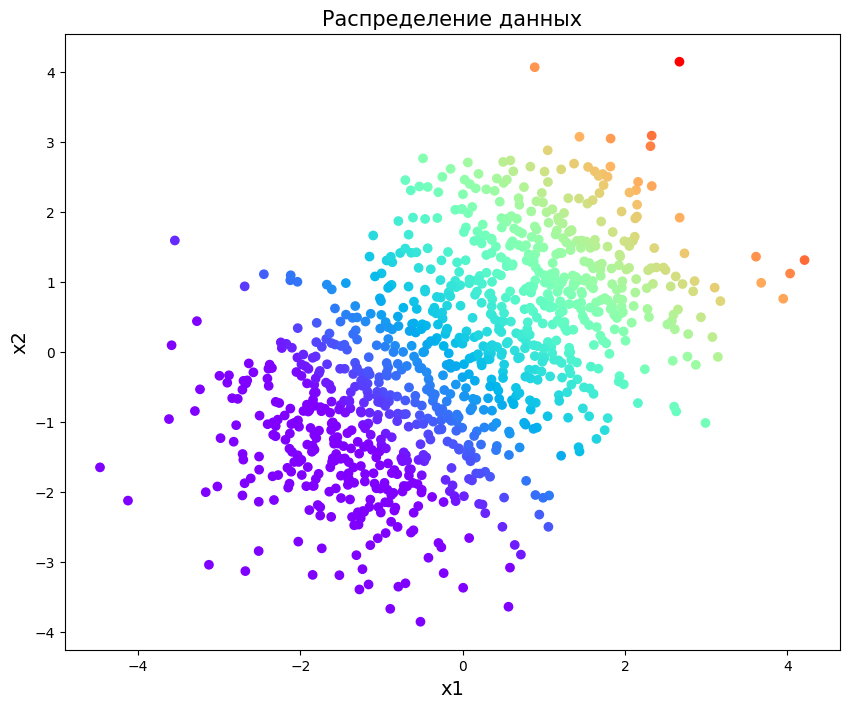

In [247]:
print('sigmoid')
plot_perc(perceptron)
print('relu')
plot_perc(perceptron_r)

Ну вот, другое дело. Однако все равно мы видим линейный решатель. 

In [248]:
print(accuracy_score(np.array(perceptron_r.forward(X) > 0.5).ravel(), y)) # рассчитаем значение accuracy

0.929


Не смотря на то, что с релу перцептрон пытается сделать более изощренное разделение, точность в совокупности оказывается хуже чем у перцептрона с сигмоидой.

Что ж, можно сделать однозначный вывод: все свои возможности перцептрон исчерпал. Пора переходить к полносвязанным нейронным сетям. 